In [15]:
import cv2
import imutils
import numpy as np
import time
from matplotlib import pyplot as plt
from keras.models import load_model
import PIL
from PIL import ImageOps

# Reference: https://www.pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/

In [92]:
def showImg(image, title="Picture"):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [93]:
samplePath = "/Users/patrickbell/Documents/sodukuAI/puzzleDetector/sample2.png"
img = cv2.imread(samplePath)

# showImg(img)

In [94]:
# AUTOMATICALLY FIND COLOR

blackLower = (0,0,0)
blackUpper = (200,200,200)

threshhold = 0.4

for i in range(img.shape[0]):
    color = img[i][i]
    if color[0] < 200 and color[1] < 200 and color[2] < 200:
        blackLower = (color[0]-color[0]*threshhold,color[1]-color[1]*threshhold,color[2]-color[2]*threshhold)
        blackUpper = (color[0]+color[0]*threshhold,color[1]+color[1]*threshhold,color[2]+color[2]*threshhold)
        break
        
print(blackLower,blackUpper)

(48.0, 48.0, 48.0) (112.0, 112.0, 112.0)


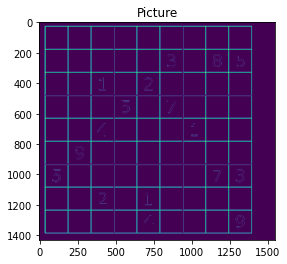

In [95]:
# Filtering by color

mask = cv2.inRange(img, blackLower, blackUpper)
showImg(mask)

[[  38 1385]
 [  38   26]
 [1397   26]
 [1397 1385]]


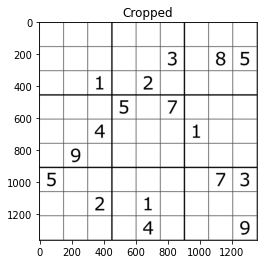

In [96]:
# Get contours

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnt = max(cnts, key=cv2.contourArea)

# Get rectangle of masked image
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
print(box)

# Assign coordinates of rectangle
topLeftCornerX = box[1][0]
topLeftCornerY = box[1][1]
bottomRightCornerX = box[3][0]
bottomRightCornerY = box[3][1]

# The image of just the grid
croppedImg = img[topLeftCornerY:bottomRightCornerY, topLeftCornerX:bottomRightCornerX]
showImg(croppedImg, "Cropped")

In [143]:
# Get 9 sub grids

subGrids = [
    [[],[],[]],
    [[],[],[]],
    [[],[],[]]
]

height, width, colorChannels = croppedImg.shape

# grid1 = img[y:ymax, x:xmax]
# grid1 = croppedImg[0:int(height/3), 0:int(width/3)]

# Loops through each grid size and adds the grid to the grids array
xInc = int(height/3)
yInc = int(width/3)
for i in range(3):
    for j in range(3):
        subGrids[i][j] = croppedImg[yInc*i:yInc*i+yInc, xInc*j:xInc*j+xInc]

# grid = subGrids[1][2]
# showImg(grid)

In [144]:
# Create cells

# Ex cells[subGridRow][subGridColumn][row][column]
cells = []

for subGridRow in range(3):
    cells.append([])
    for subGridColumn in range(3):
        cells[subGridRow].append([])
        for row in range(3):
            cells[subGridRow][subGridColumn].append([])
            for column in range(3):
                cells[subGridRow][subGridColumn][row].append(None)
                
                
for subGridRow in range(3):
    for subGridColumn in range(3):
        subGridImg = subGrids[subGridRow][subGridColumn]
        subGridImgHeight, subGridImgWidth, subGridImgColorChannels = subGridImg.shape
        xInc = int(subGridImgHeight/3)
        yInc = int(subGridImgWidth/3)
        for i in range(3):
            for j in range(3):
                cells[subGridRow][subGridColumn][i][j] = subGridImg[yInc*i:yInc*i+yInc, xInc*j:xInc*j+xInc]



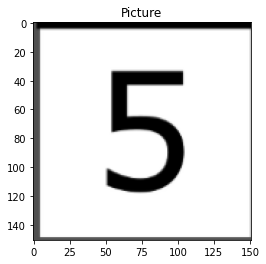

In [145]:
cell = cells[2][0][0][0]
showImg(cell)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [100]:
# Loads the model and class names

new_model = tf.keras.models.load_model('/Users/patrickbell/Documents/sodukuAI/digitClassifier/wholeModelSave')
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']
# Pick cell and save/load it

cell = cells[1][0][1][2]

imagePath = "/Users/patrickbell/Documents/sodukuAI/digitClassifier/testImg.png"
resizedCell = cv2.resize(cell, (100,100), interpolation = cv2.INTER_AREA)
img = PIL.Image.fromarray(resizedCell)
image = ImageOps.grayscale(img)
image.save(imagePath)


img = keras.preprocessing.image.load_img(
    imagePath, target_size=(100, 100)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
showImg(img)

# Predict

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
# showImg(img)

In [146]:
new_model = tf.keras.models.load_model('/Users/patrickbell/Documents/sodukuAI/digitClassifier/wholeModelSave')
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']

def convertImageToNumber(model, img):
    imagePath = "/Users/patrickbell/Documents/sodukuAI/digitClassifier/testImg.png"
    resizedCell = cv2.resize(img, (100,100), interpolation = cv2.INTER_AREA)
    img = PIL.Image.fromarray(resizedCell)
    image = ImageOps.grayscale(img)
    image.save(imagePath)
    img = keras.preprocessing.image.load_img(
        imagePath, target_size=(100, 100)
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    prediction = class_names[np.argmax(score)]
    return prediction
    

In [148]:
# Recreates all the cells

numberedCells = copy.deepcopy(cells)

for subGridRow in range(3):
    for subGridColumn in range(3):
        for i in range(3):
            for j in range(3):
                numberedCells[subGridRow][subGridColumn][i][j] = convertImageToNumber(new_model, cells[subGridRow][subGridColumn][i][j])

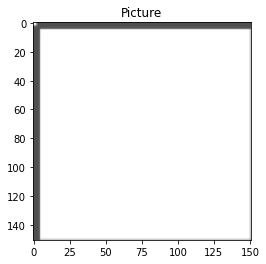

Predicted: blank


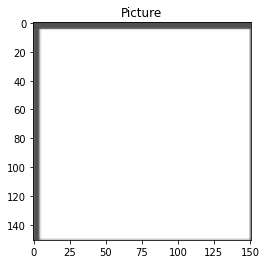

Predicted: blank


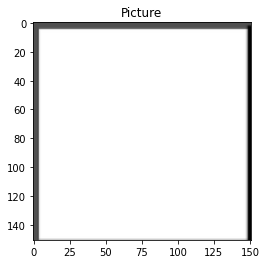

Predicted: blank


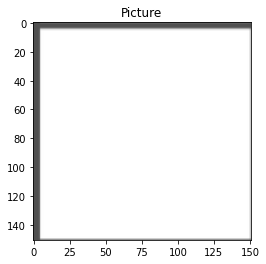

Predicted: blank


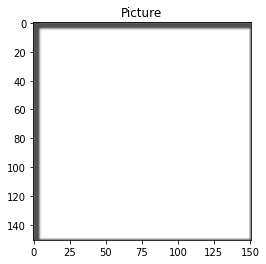

Predicted: blank


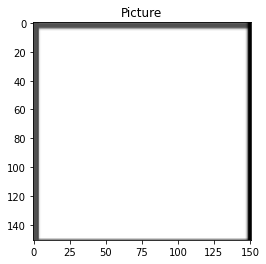

Predicted: blank


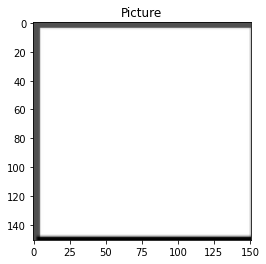

Predicted: blank


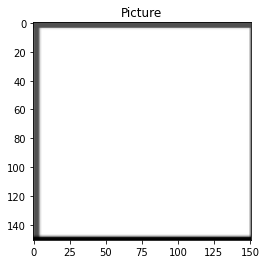

Predicted: blank


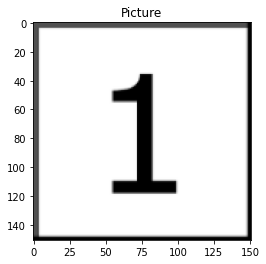

Predicted: 1


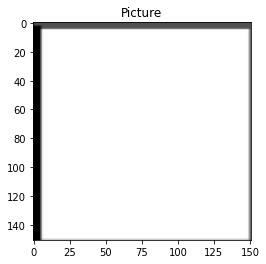

Predicted: blank


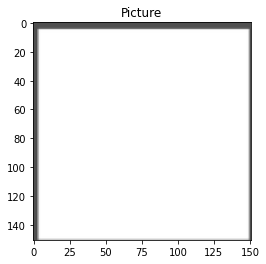

Predicted: blank


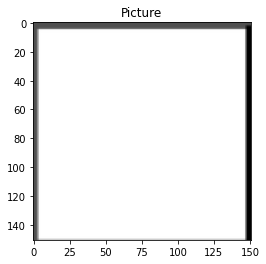

Predicted: blank


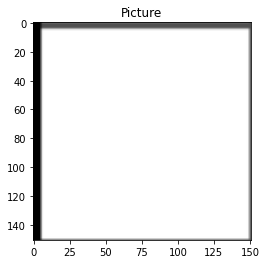

Predicted: blank


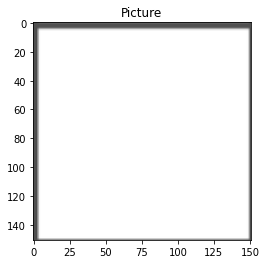

Predicted: blank


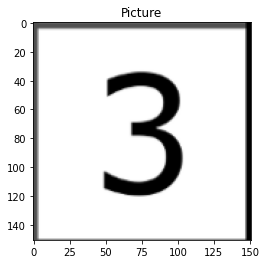

Predicted: 3


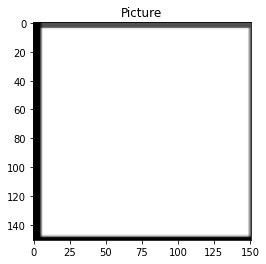

Predicted: blank


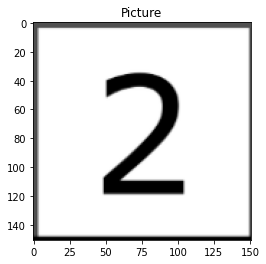

Predicted: 2


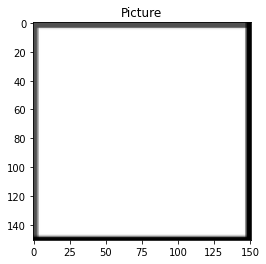

Predicted: blank


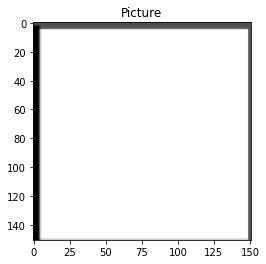

Predicted: blank


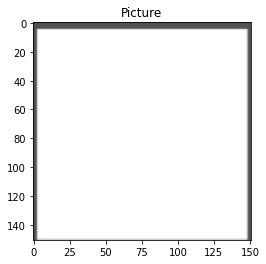

Predicted: blank


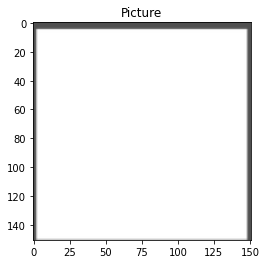

Predicted: blank


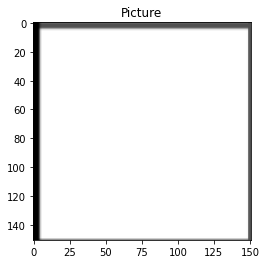

Predicted: blank


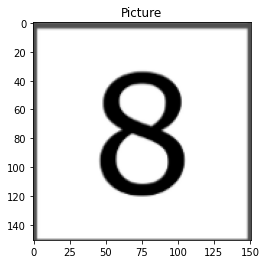

Predicted: 8


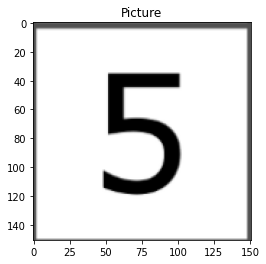

Predicted: 5


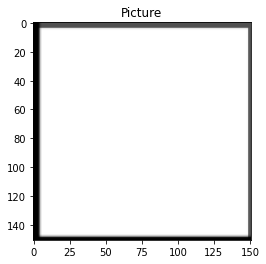

Predicted: blank


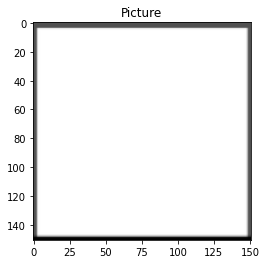

Predicted: blank


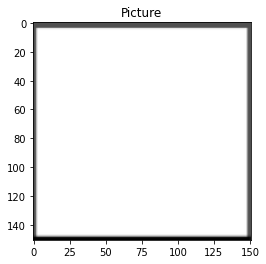

Predicted: blank


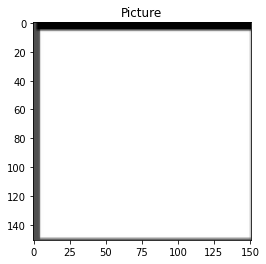

Predicted: blank


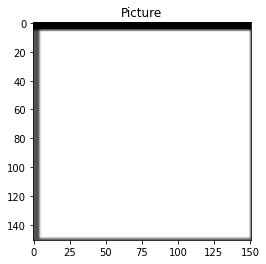

Predicted: blank


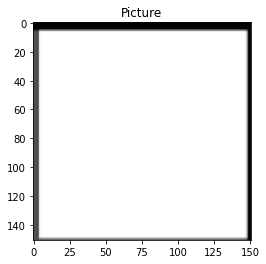

Predicted: blank


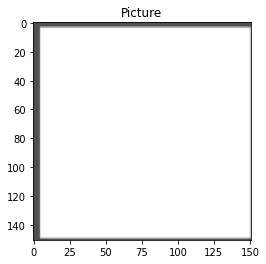

Predicted: blank


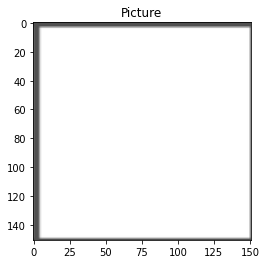

Predicted: blank


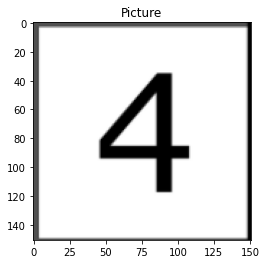

Predicted: 4


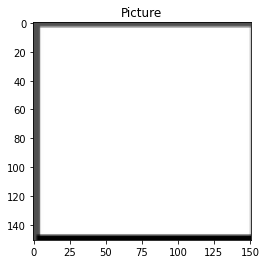

Predicted: blank


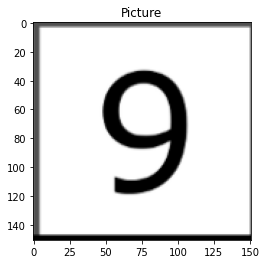

Predicted: 9


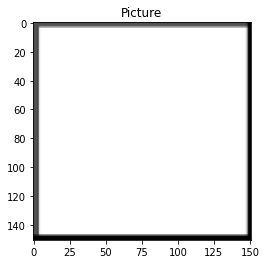

Predicted: blank


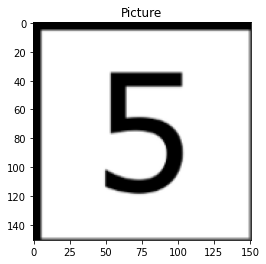

Predicted: 5


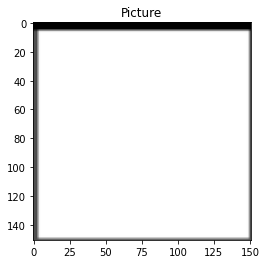

Predicted: blank


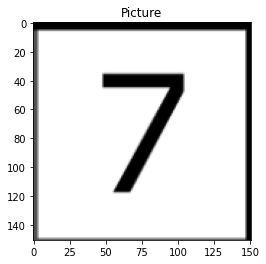

Predicted: 7


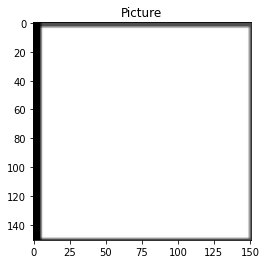

Predicted: blank


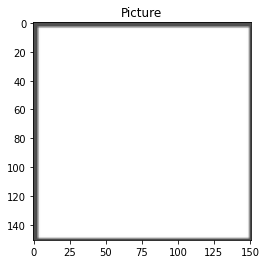

Predicted: blank


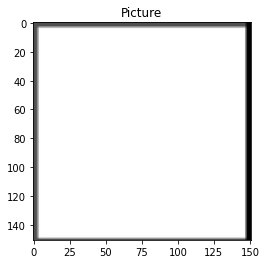

Predicted: blank


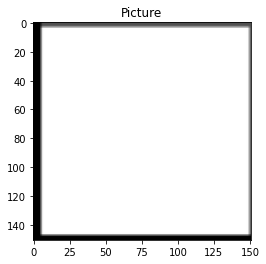

Predicted: blank


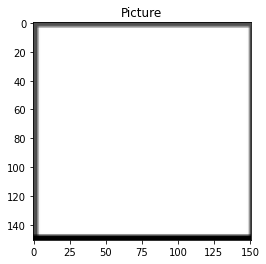

Predicted: blank


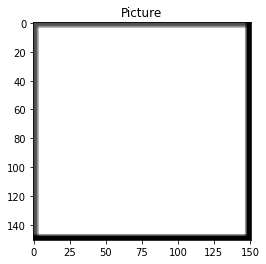

Predicted: blank


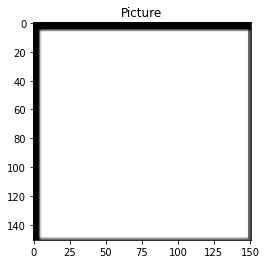

Predicted: blank


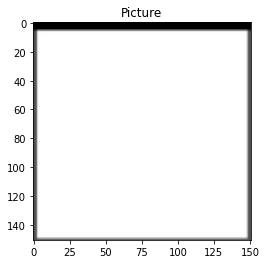

Predicted: blank


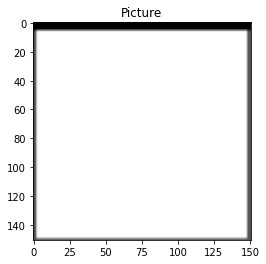

Predicted: blank


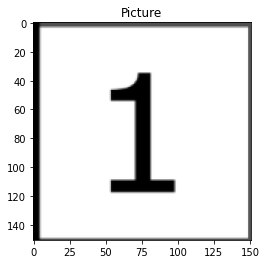

Predicted: 1


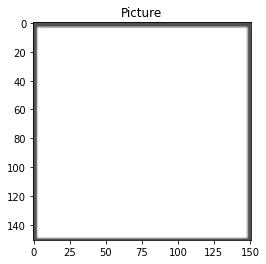

Predicted: blank


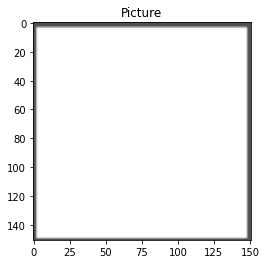

Predicted: blank


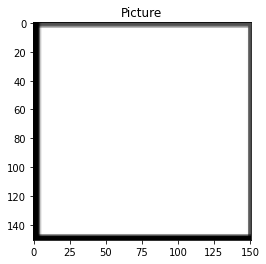

Predicted: blank


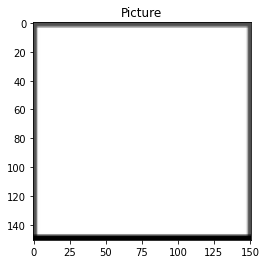

Predicted: blank


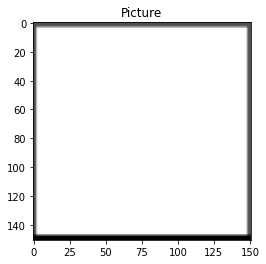

Predicted: blank


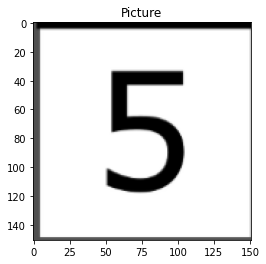

Predicted: 5


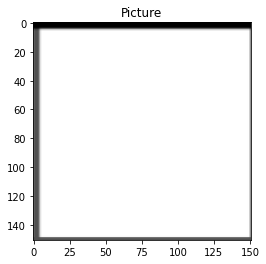

Predicted: blank


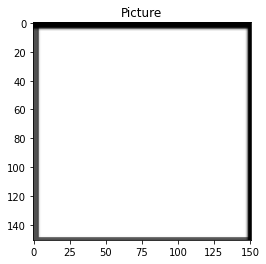

Predicted: blank


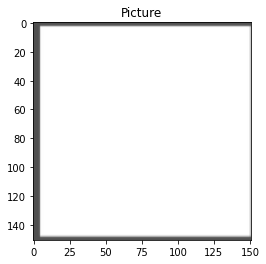

Predicted: blank


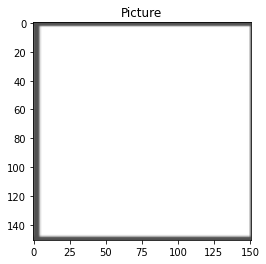

Predicted: blank


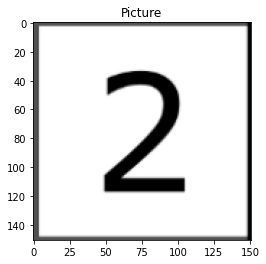

Predicted: 2


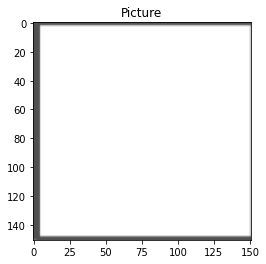

Predicted: blank


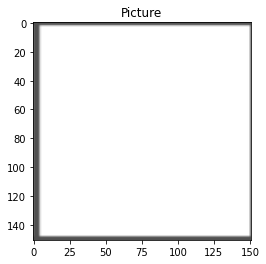

Predicted: blank


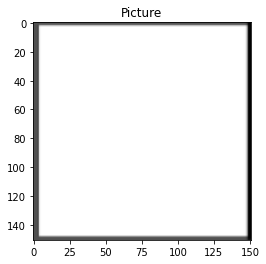

Predicted: blank


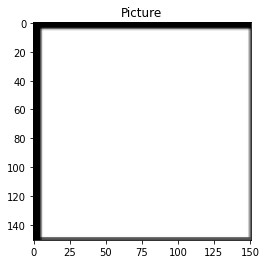

Predicted: blank


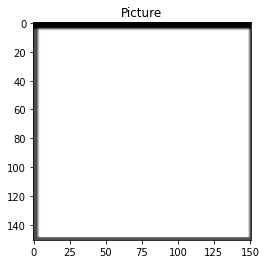

Predicted: blank


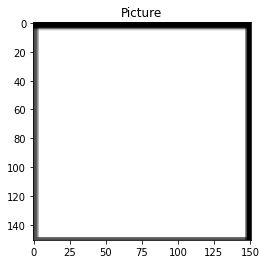

Predicted: blank


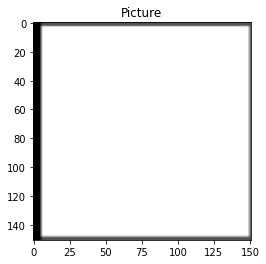

Predicted: blank


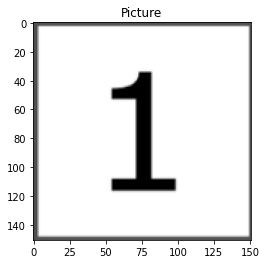

Predicted: 1


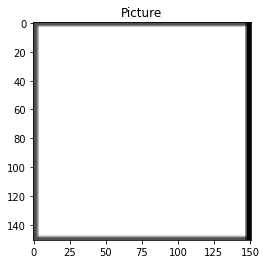

Predicted: blank


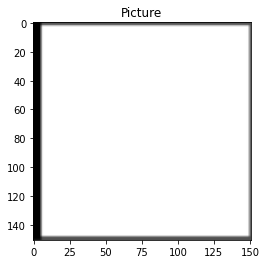

Predicted: blank


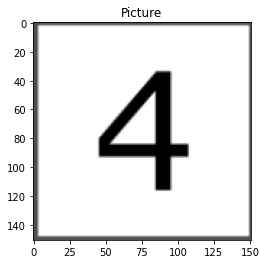

Predicted: 4


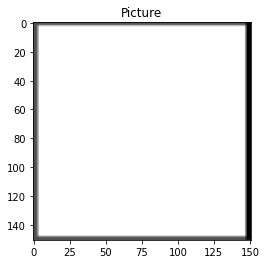

Predicted: blank


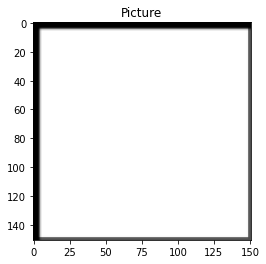

Predicted: blank


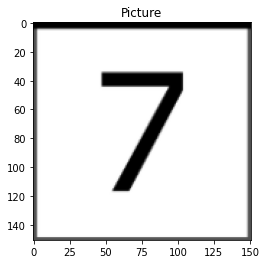

Predicted: 7


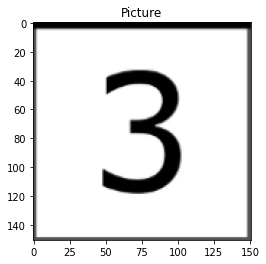

Predicted: 3


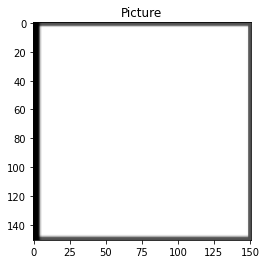

Predicted: blank


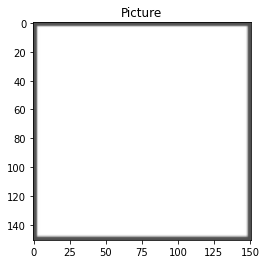

Predicted: blank


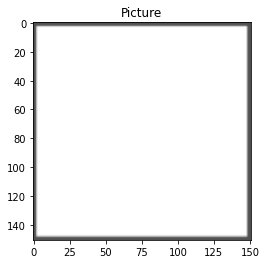

Predicted: blank


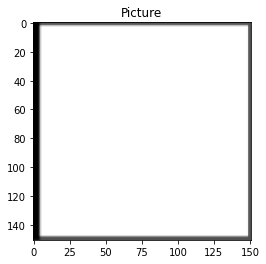

Predicted: blank


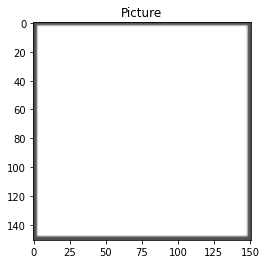

Predicted: blank


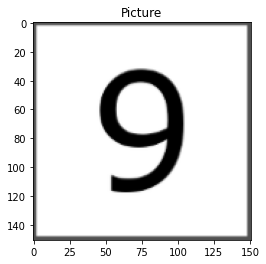

Predicted: 9


In [151]:
# Check results

def showComparison(num1,num2,num3,num4):
    showImg(cells[num1][num2][num3][num4])
    print("Predicted: " + str(numberedCells[num1][num2][num3][num4]))


for subGridRow in range(3):
    for subGridColumn in range(3):
        for i in range(3):
            for j in range(3):
                showComparison(subGridRow,subGridColumn,i,j)
                time.sleep(0.5)


In [142]:
import copy